# Classifier comparison

This notebook takes multiple files and does the following pipeline:
1) Import data and pre-process
2) For each stimulus type 
    1) Run classifiers (i.e., CCA, MEC, MSI, and RG)
    2) Store accuracy values

A final plot for each stimulus type is plotted 

In [1]:
# Default libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Import custom libraries
from functions import data_tools
from functions import processing
from functions import classification
from functions.FeatureExtractorSSVEP import FeatureExtractorCCA as CCA
from functions.FeatureExtractorSSVEP import FeatureExtractorMSI as MSI
from functions.FeatureExtractorSSVEP import FeatureExtractorMEC as MEC

# Magic command to reload libraries
%reload_ext autoreload


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\danie\miniconda3\envs\ssvep-validation\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


## Settings


In [2]:
files = [
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P003\ses-S001\eeg\sub-P003_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P004\ses-S001\eeg\sub-P004_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P005\ses-S001\eeg\sub-P005_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P007\ses-S001\eeg\sub-P007_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P008\ses-S001\eeg\sub-P008_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P009\ses-S001\eeg\sub-P009_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P019\ses-S001\eeg\sub-P019_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P022\ses-S001\eeg\sub-P022_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P023\ses-S001\eeg\sub-P023_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P024\ses-S001\eeg\sub-P024_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P031\ses-S001\eeg\sub-P031_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P031\ses-S001\eeg\sub-P031_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P033\ses-S001\eeg\sub-P033_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P034\ses-S001\eeg\sub-P034_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P035\ses-S001\eeg\sub-P035_ses-S001_task-T1_run-001_eeg.xdf",
    r"C:\Users\danie\OneDrive - University of Calgary\PDF\Proyects\Datasets\easy-on-the-eyes\sub-P036\ses-S001\eeg\sub-P036_ses-S001_task-T1_run-001_eeg.xdf",
    ]

# Import and epoch data
eeg_channels = ["O1","Oz","O2"]
# eeg_channels = "all"
# stimulus_types = ['MaxContrast', 'WoodGrain', 'Worms', 'Voronoi', 'MinContrast', 'Checkerboard', 'Static'] # Complete list of stimulus types
stimulus_types = ['WoodGrain', 'Worms', 'Voronoi', 'Static'] # Complete list of stimulus types
stimulus_freqs = {0:"9.090909", 1:"14.28571", 2:"33.33333"}
list_of_freqs = [float(freq) for freq in stimulus_freqs.values()]
event_labels = np.array([0,0,0,1,1,1,2,2,2])

# Preprocessing settings
fc_low = 0.1    # Cut frequency for the high-pass filter [Hz]
fc_high = 100   # Cut frequency for the low-pass filter [Hz]
order = 4       # Order of the Butterworth filter

# Classifier settings
first_column = np.arange(1, 40, 3)
second_column = np.full(first_column.shape, 40)
cca_filterbank = np.column_stack((first_column, second_column))
cv = 3  # Number of cross-validation folds for RG classifier
# cca_subbands = np.array((
#     (7,11),
#     (12,16),
#     (31,35),
#     (16,20),
#     (26,30),
#     (64,68)
#     ))

# Create an empty dataframe to store the accuracies
accuracy_df = pd.DataFrame(columns=["Subject", 'Stimulus', 'fbCCA', 'MSI', 'MEC', 'RG_logreg'])

## Comparison pipeline

In [3]:
for file in files:
    # Extract subject number from file name
    subject_number = re.findall(r'sub-P(\d+)', file)[0]

    # Import data and markers
    [eeg_time, eeg, srate] = data_tools.read_xdf(file, picks=eeg_channels)
    [marker_time, markers] = data_tools.read_xdf_unity_markers(file)

    # Bandpass filter the EEG
    eeg_filtered = processing.bandpass_filter(
        eeg = eeg,
        srate = srate,
        f_low = fc_low,
        f_high = fc_high,
        f_order = order
        )

    # Filter 60 Hz noise
    eeg = processing.line_filter(eeg=eeg, srate=srate, f_notch=60, f_order=4)

    # Epoch data
    [eeg_epochs, epoch_labels] = data_tools.epochs_from_unity_markers(
        eeg_time = eeg_time,
        eeg_data = eeg_filtered,
        marker_time = marker_time,
        marker_data = markers
        )

    # Get stimuli and frequencies labels
    fixed_labels = data_tools.fix_labels(epoch_labels)          # Fix labels that might be incorrect in pilot trials
    dict_of_stimuli = data_tools.get_tvep_stimuli(fixed_labels) # Dictionary of unique stimulus

    # - Create array of eeg epochs organized as [stimuli, freq, chans, samples]
    eeg_epochs_organized = data_tools.epochs_stim_freq(
        eeg_epochs = eeg_epochs,
        labels = fixed_labels,
        stimuli = dict_of_stimuli,
        freqs = stimulus_freqs,
        mode = "zeropad"
        )
    
    # Initialize classifiers
    cca = CCA()
    msi = MSI()
    mec = MEC()

    # Initialize feature extractors
    cca.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = list_of_freqs,
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        filter_order = 12,
        subbands = cca_filterbank
        )
    
    msi.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = list_of_freqs,
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        )
    
    mec.setup_feature_extractor(
        harmonics_count = 2,
        targets_frequencies = list_of_freqs,
        sampling_frequency = srate,
        samples_count = eeg_epochs_organized.shape[-1],
        )

    for s, stimulus in dict_of_stimuli.items():
        # Organize data
        nevents = len(event_labels)
        nsamples = eeg_epochs_organized.shape[-1]
        nchans = eeg_epochs_organized.shape[-2]
        classifier_data = eeg_epochs_organized[s,:,:,:,:].reshape(nevents,nchans,nsamples)
       
        # Get features
        cca_features = cca.extract_features(classifier_data)
        msi_features = msi.extract_features(classifier_data)
        mec_features = mec.extract_features(classifier_data)

        # Get predictions
        cca_predictions = np.argmax(np.max(np.squeeze(cca_features), axis=1), axis=1)
        msi_predictions = np.argmax(np.squeeze(msi_features), axis=1)
        mec_predictions = np.argmax(np.squeeze(mec_features), axis=1)
        rg_predictions = classification.rg_logreg(
            eeg_data = classifier_data,
            labels = event_labels,
            cv = cv,
            )

        # Compute accuracy
        cca_accuracy = accuracy_score(event_labels, cca_predictions)
        msi_accuracy = accuracy_score(event_labels, msi_predictions)
        mec_accuracy = accuracy_score(event_labels, mec_predictions)
        rg_accuracy = accuracy_score(event_labels, rg_predictions)
        

        # Organize results
        temp_df = pd.DataFrame({
            "Subject": subject_number,
            'Stimulus': stimulus.split(" ")[-1],
            'fbCCA': cca_accuracy,
            'MSI': msi_accuracy,
            'MEC': mec_accuracy,
            'RG_logreg': rg_accuracy},
            index=[0])
        
        accuracy_df = pd.concat([accuracy_df, temp_df], ignore_index=True)



## Visualization

### Stripplot

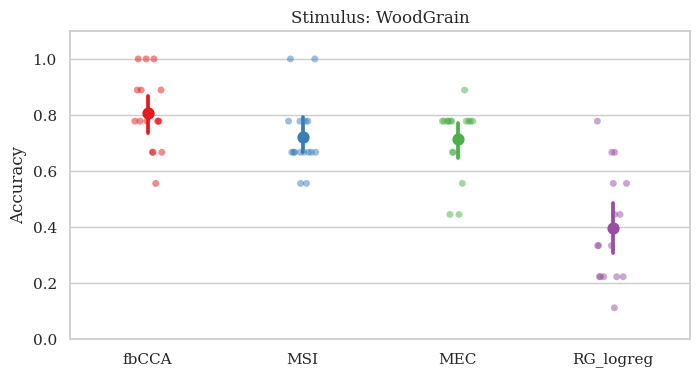

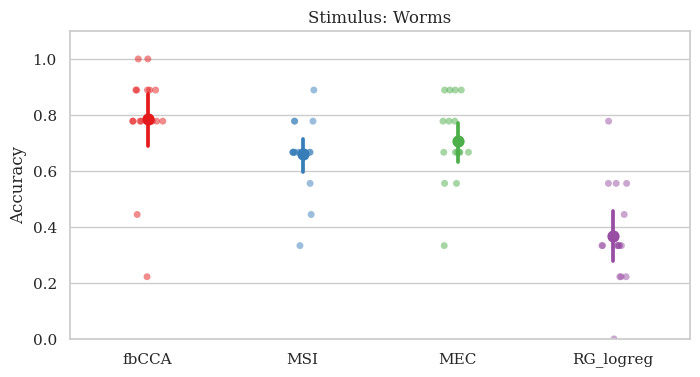

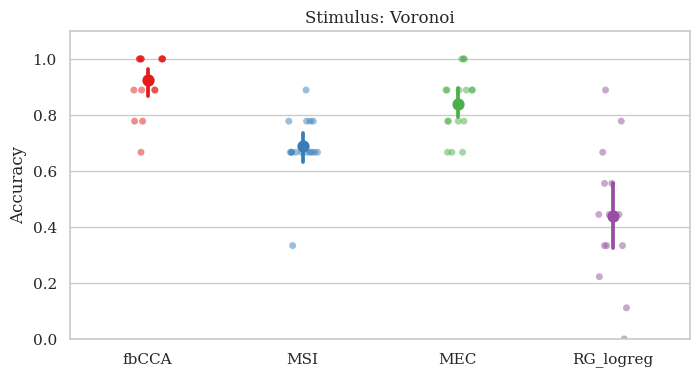

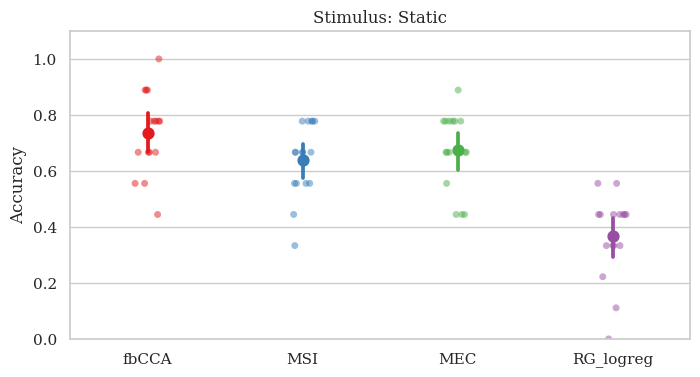

In [4]:
# Settings 
save_plots = True

classifiers = ['fbCCA', 'MSI', 'MEC', 'RG_logreg']

for (s,stimulus) in enumerate(stimulus_types):
    stimulus_accuracy = accuracy_df[accuracy_df["Stimulus"]==stimulus]

    fig, ax = plt.subplots(facecolor="white", figsize=[8, 4])
    sns.stripplot(
        data=stimulus_accuracy,
        ax=ax,
        jitter=True,
        alpha=0.5,
        zorder=1,
        palette="Set1",
    )
    sns.pointplot(data=stimulus_accuracy, ax=ax, palette="Set1")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1.1)
    ax.set_title(f"Stimulus: {stimulus}")
    plt.show()

    if save_plots:
        fig.savefig(f"figures\{stimulus}_comparison.svg")

### Boxplots

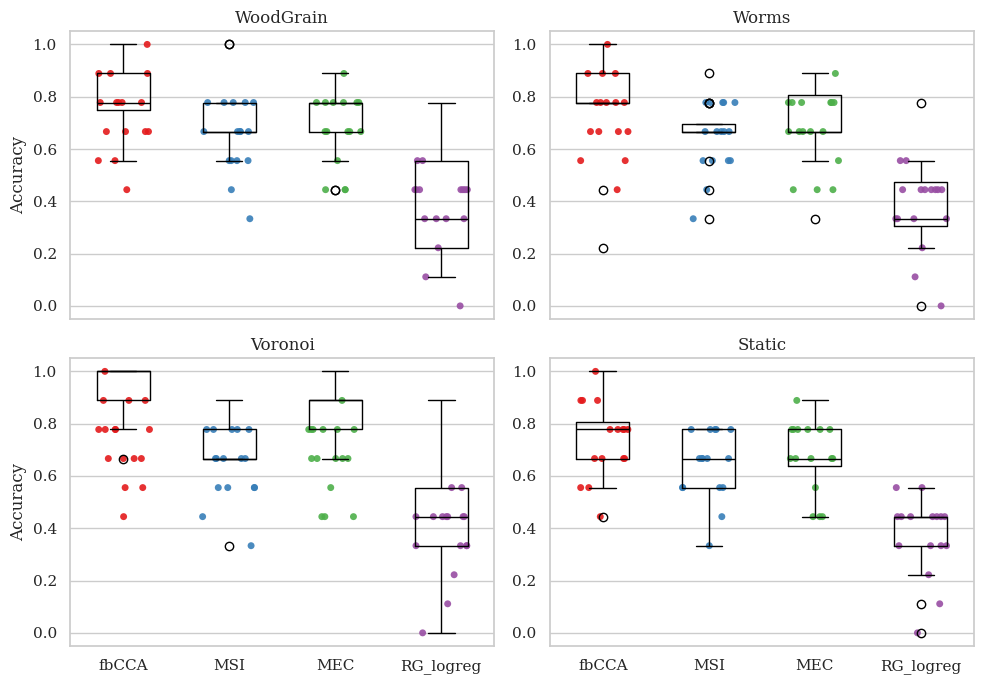

In [52]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(10, 7))


# Iterate over each stimulus type
for i, (stimulus, ax) in enumerate(zip(stimulus_types, axs.flatten())):
    # Filter the accuracy dataframe for the current stimulus type
    stimulus_df = accuracy_df[accuracy_df['Stimulus'] == stimulus]

    sns.boxplot(
        data = stimulus_df[classifiers],
        ax = ax,
        color = "black",
        fill = False,
        width = 0.5,
        linewidth = 1   
    )

    sns.stripplot(
        data=stimulus_accuracy,
        ax=ax,
        jitter=0.25,
        alpha=0.9,
        zorder=1,
        palette="Set1",
    )

    ax.set_title(stimulus)
    ax.set_ylim(-0.05, 1.05) 

axs[0,0].set_ylabel("Accuracy")
axs[1,0].set_ylabel("Accuracy")
axs[0,0].set_xticklabels("")
axs[0,1].set_xticklabels("")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot
fig.savefig("figures\\boxplot_comparison.svg")
